## SMS Spam Detection
This is a binary classification problem to state if a SMS is either spam (1) or not spam (0). 

We implement Dense Text Classifier, Long Short Term Memory (LSTM) and Bidirectional-LSTM (Bi-LSTM) 
deep learning models in TensorFlow2 Keras API.

Dataset: https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection
The SMS (text) data was downloaded from UCI datasets. It contains 5,574 SMS phone messages. The data have already been marked as either spam or not spam (ham).

### Import required packages


In [1]:
#libraries for reading data, exploratory analysis and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud  #### conda install -c https://conda.anaconda.org/conda-forge wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

# library for train test split
from sklearn.model_selection import train_test_split

# deep learning libraries for text pre-processing and feature engineering
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

# Performance Metrics
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score

### Loading the dataset

In [2]:
url = 'smsspamcollection/SMSSpamCollection'
df = pd.read_csv(url, sep ='\t', names=["label", "message"])
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [4]:
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [5]:
df[df.duplicated()]

,label,message
103,ham,As per your request 'Melle Melle (Oru Minnamin...
154,ham,As per your request 'Melle Melle (Oru Minnamin...
207,ham,"As I entered my cabin my PA said, '' Happy B'd..."
223,ham,"Sorry, I'll call later"
326,ham,No calls..messages..missed calls
...,...,...
5524,spam,You are awarded a SiPix Digital Camera! call 0...
5535,ham,"I know you are thinkin malaria. But relax, chi..."
5539,ham,Just sleeping..and surfing
5553,ham,Hahaha..use your brain dear


In [6]:
df.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

In [7]:
ham_msg = df[df.label =='ham']
spam_msg = df[df.label=='spam']

# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

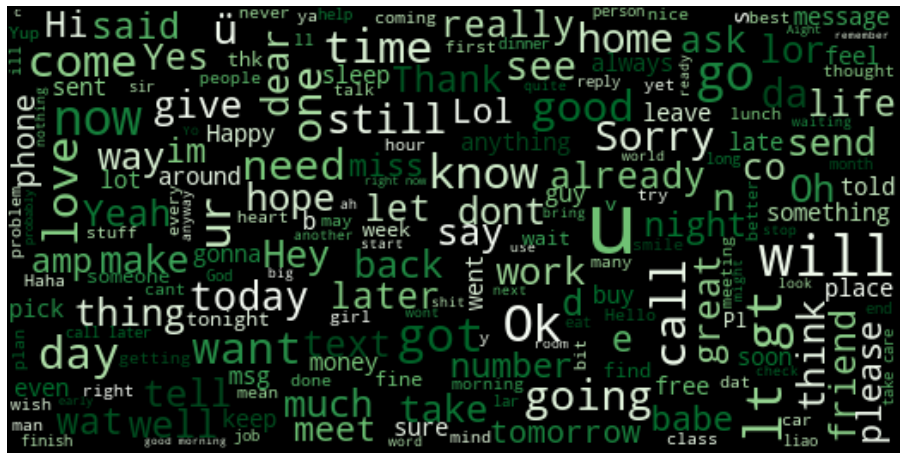

In [8]:
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS, max_font_size=50, background_color ="black", colormap='Greens').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

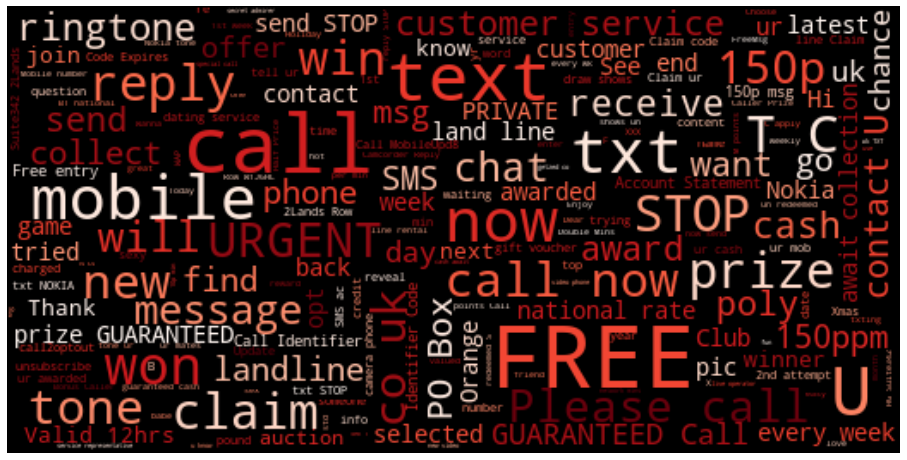

In [9]:
# wordcloud of spam messages
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Reds').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

15.481865284974095

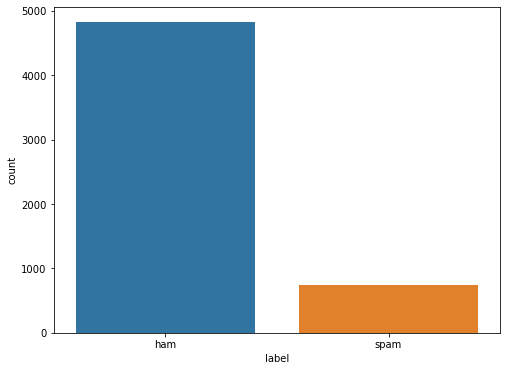

In [10]:
# we  can observe an imbalance in the data here 
plt.figure(figsize=(8,6))
sns.countplot(df.label)

# Percentage of spam messages
(len(spam_msg)/len(ham_msg))*100 # 15.48%

There are several ways to handle the imbalance data, for instance
* use of appropriate evaluation metrics
* resampling the training set : oversampling/upsampling or undersampling/downsampling
* ensemble different resample datasets

Here, we use downsampling. Downsampling is a process where you randomly delete some of the observations from the majority class so that the numbers in majority and minority classes are matched. Below, we have downsampled the ham messages (majority class). There are now 747 messages in each class.


In [11]:
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg
print(ham_msg_df.shape, spam_msg_df.shape)

(747, 2) (747, 2)


Text(0.5, 0, 'Message types')

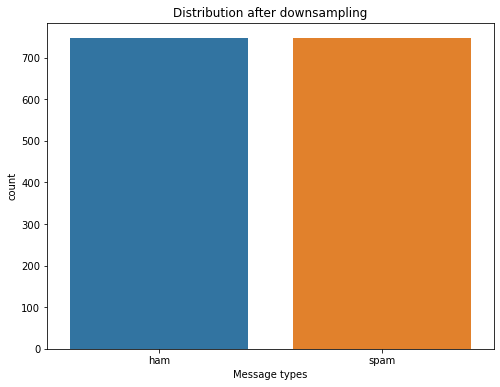

In [12]:
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.countplot(msg_df.label)
plt.title('Distribution after downsampling')
plt.xlabel('Message types')

In [13]:
# Get length column for each text
msg_df['text_length'] = msg_df['message'].apply(len)

#Calculate average length by label types
labels = msg_df.groupby('label').mean()
labels

,text_length
label,
ham,73.238286
spam,138.670683


### Prepare train/test data and pre-process text

In [14]:
# Map ham label as 0 and spam as 1
msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values

In [15]:
# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'], msg_label, test_size=0.2, random_state=434)

#### Text pre-processing which includes Tokenization, Sequencing and Padding

Text -> Tokens -> Word Index -> Sequence -> Padded Sequence

["My Name", "is Sneha Kedia"] -> ["My", "Name", "is", "Sneha", "Kedia"] -> ["My": 1, "Name": 2, "is": 3, "Sneha": 4, "Kedia" : 5] -> [[1, 2], [3, 4, 5]] -> [[0, 1, 2], [3, 4, 5]]

#### Tokenization

The Tokenizer API from TensorFlow Keras splits sentences into words and encodes these into integers. Tokenizer() does all the required pre-processing such as
* tokenize into word or character — here we use at word level
* num_words for maximum number of unique tokens hence we can filter out rare words
* filter out punctuation terms
* convert all words to lower case
* convert all words to integer index

Hyper-parameters used in Tokenizer object are: num_words and oov_token, char_level.
* num_words: Indicate how many unique words to load in training and testing data. For our purpose, we selected 500 words (vocab_size)
* oov_token: When its used, out of vocabulary token will be added to word index in the corpus which is used to build the model. This is used to replace out of vocabulary words (words that are not in our corpus) during text_to_sequence calls (see below).
* char_level: If it is “True” then every character will be treated as a token. We set it as “False”, hence every word will be treated as a token.

In [16]:
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 500

In [17]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [18]:
# Get the word_index 

word_index = tokenizer.word_index
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)
word_index

There are 4169 unique tokens in training data. 


{'<OOV>': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'i': 5,
 'call': 6,
 'the': 7,
 'u': 8,
 'your': 9,
 'for': 10,
 'is': 11,
 '2': 12,
 'and': 13,
 'now': 14,
 'free': 15,
 'or': 16,
 'on': 17,
 'in': 18,
 'ur': 19,
 'have': 20,
 '4': 21,
 'txt': 22,
 'of': 23,
 'are': 24,
 'with': 25,
 'me': 26,
 'from': 27,
 'text': 28,
 'get': 29,
 'my': 30,
 'it': 31,
 'stop': 32,
 'just': 33,
 'mobile': 34,
 'this': 35,
 'will': 36,
 'be': 37,
 'no': 38,
 'that': 39,
 'claim': 40,
 'reply': 41,
 'can': 42,
 'so': 43,
 'send': 44,
 'www': 45,
 'we': 46,
 'only': 47,
 'our': 48,
 'not': 49,
 'out': 50,
 'at': 51,
 'do': 52,
 'if': 53,
 'prize': 54,
 'new': 55,
 'go': 56,
 'cash': 57,
 'but': 58,
 '150p': 59,
 'uk': 60,
 '1': 61,
 'nokia': 62,
 'who': 63,
 't': 64,
 'all': 65,
 'win': 66,
 'please': 67,
 'won': 68,
 'up': 69,
 'tone': 70,
 'when': 71,
 "i'm": 72,
 'week': 73,
 'been': 74,
 'what': 75,
 'msg': 76,
 '50': 77,
 'com': 78,
 'urgent': 79,
 'how': 80,
 'service': 81,
 'phone': 82,
 'time': 83,
 

#### Sequencing and Padding
After tokenization, we represent each sentence by sequences of numbers using texts_to_sequences() 
from tokenizer object. Subsequently, we use pad_sequences() so that each sequence will have same length. 
Sequencing and padding are done for both training and testing data.

In [19]:
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type)
testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type)

* padding = ‘pre’ or ‘post (default pre). By using pre, we pad before each sequence and by using post we pad after each sequence.
* maxlen = maximum length of all sequences. Here max_len=50 hence, we are only going to use 50 words in a sentence. If not provided, by default it will use the maximum length of the longest sentence.
* truncating = ‘pre’ or ‘post’ (default ‘pre’). If a sequence length is larger than the provided maxlen value then, these values will be truncated to maxlen. ‘pre’ option will truncate at the beginning where as ‘post’ will truncate at the end of the sequences.

In [20]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


In [21]:
# Before padding
print(len(training_sequences[0]), len(training_sequences[1]))

# After padding
print(len(training_padded[0]), len(training_padded[1]))

print("\n", training_padded[0])

27 24
50 50

 [  1  47 186   9  34   1   3  24   1   2 274   2   7 152 275 135  34  10
  15   6   7  34 274  85  15  17   1   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


### Dense Spam Detection Model

In [22]:
# Defining Hyper Parameters

vocab_size = 500 # As defined earlier
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

* Sequential calls for Keras sequential model in which layers are added in a sequence

* The first layer i.e. embedding layer maps each word to a N-dimensional vector of real numbers. The embeding_dim is the size of this vector which is 16 in our case. The embedding layer indicates that the two words with a similar meaning tend to have very close vectors. Because, the embedding layer is the first hidden layer in our model network, we need to pass shape of our input layer as defined by input_length (max_len =50).

* The pooling layer helps to reduce the number of parameters in the model hence helps to avoid overfitting. We can use the Flatten layer as it is useful for reducing the multi-dimensional tensors to a one-dimensional tensor for analysis purposes. However, it is possible for Global Average Pooling to better represent the vector by averaging across the data. Flatten risks over-fitting by potentially resulting in a heavier Dense layer, depending on the amount of data. Hence, we have tried to show both. The layer is 1 dimensional.

* Next, we use a dense layer with activation function ‘relu’ followed by a dropout layer to avoid overfitting and a final output layer with sigmoid activation function. As there are only two classes (ham or spam) to classify, we use only a single output neuron. The sigmoid activation function outputs probabilities between 0 and 1.

Here, we use fairly a shallow neural network architecture, however, you can make it more dense adding more layers.

In [23]:
#Dense model architecture with GlobalAveragePooling1D Layer

model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            8000      
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
_________________________________________________________________


The model.summary() below, provides the layer, shape and number of parameters used in each layer. In the embedding layer, the 8000 parameter comes from 500 words (vocab_size), each one with a 16 dimensional word-vector space (500 X 16 =8000). The embedding layer is passed through GlobalAveragePooling1D and into dense layers have shape of 16 (due to the average pooling along 16 embedding dimension). We selected 24 neurons for the dense hidden layer. Each of the 24 neurons in the dense layer gets input from each of the 16 values coming from the GlobalAveragePooling1D layer, for a total of 384 (16 X 24) weights and 24 biases (one for each 24 neurons). Hence the total parameter is 408. Finally, the output layer has 24 weights (one for each neuron) and its one bias term resulting 25 parameters in total.

#### Compiling the Dense model

We use
* ‘binary_crossentropy’ as a loss function because of binary output, 
* ‘adam’ as an optimiser which makes use of momentum to avoid local minima and 
* ‘accuracy’ as a measure of model performance.


In [25]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

#### Training and evaluating the Dense model

Next, we fit our dense classifier using model.fit() argument. 
It uses padded training data and training labels for training the model and validation data for validating.
* epoch: Number of times the learning algorithm will work through the entire training data set. We set it to be 20.
* callbacks: callbacks is used to pass the early stopping parameter. 
     EarlyStopping(monitor=’val_loss’, patience=2) is used to define that we want to monitor the validation loss and if the validation loss is not improved after two epochs, then the model training is stopped. It helps to avoid overfitting problem and indicates when to stop training before the learner begins over-fit. As depicted in the history results below, the validation loss is increased (i.e. not improved), continuously for 2 epochs (epoch 24: 0.12, and epoch 25: 0.13) after epoch 23, hence the model fitting has stopped at epoch 26.
* verbose =2: lets to print loss and accuracy on each epoch

In [26]:
# fitting a dense spam detector model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 1s - loss: 0.6853 - accuracy: 0.7657 - val_loss: 0.6749 - val_accuracy: 0.7659
Epoch 2/30
38/38 - 0s - loss: 0.6572 - accuracy: 0.8234 - val_loss: 0.6342 - val_accuracy: 0.7960
Epoch 3/30
38/38 - 0s - loss: 0.5993 - accuracy: 0.8536 - val_loss: 0.5653 - val_accuracy: 0.8528
Epoch 4/30
38/38 - 0s - loss: 0.5141 - accuracy: 0.8753 - val_loss: 0.4764 - val_accuracy: 0.8696
Epoch 5/30
38/38 - 0s - loss: 0.4181 - accuracy: 0.8937 - val_loss: 0.3962 - val_accuracy: 0.8763
Epoch 6/30
38/38 - 0s - loss: 0.3396 - accuracy: 0.9021 - val_loss: 0.3329 - val_accuracy: 0.8829
Epoch 7/30
38/38 - 0s - loss: 0.2790 - accuracy: 0.9163 - val_loss: 0.2822 - val_accuracy: 0.8930
Epoch 8/30
38/38 - 0s - loss: 0.2311 - accuracy: 0.9255 - val_loss: 0.2436 - val_accuracy: 0.8997
Epoch 9/30
38/38 - 0s - loss: 0.1978 - accuracy: 0.9372 - val_loss: 0.2096 - val_accuracy: 0.9130
Epoch 10/30
38/38 - 0s - loss: 0.1729 - accuracy: 0.9456 - val_loss: 0.1928 - val_accuracy: 0.9264
Epoch 11/30
38/38 -

In [27]:
# Model performance on test data 
model.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 978us/step - loss: 0.1241 - accuracy: 0.9465


[0.12411334365606308, 0.9464883208274841]

We further visualize the history results by plotting loss and accuracy by number of epochs.

In [28]:
# Read as a dataframe 
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

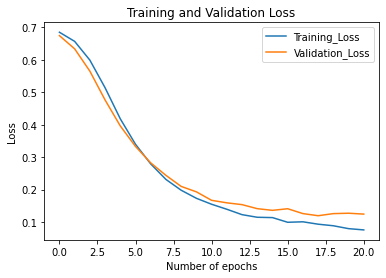

In [29]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'Loss')

We observe that the loss is decreasing as the number of epochs increases. The validation loss is higher than training loss after around 5 epochs and the difference is more pronounced with increase in epochs.

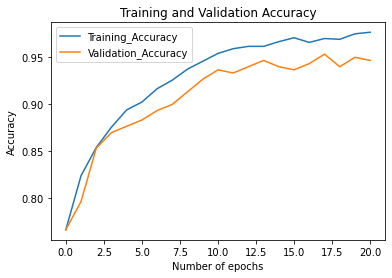

In [30]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'Accuracy')

The accuracy plot shows the accuracy is increasing over epochs. As expected, the model is performing better in training set than the validation set. If the model performs very well on training data, however, its performance is worse in testing data, then it is an indication of overfitting. In our model, we don’t see a significant issue with over-fitting. Moreover, we have accounted for over-fitting problem by using dropout layer and callback earlier.

In [31]:
y_predict = [1 if o > 0.5 else 0 for o in model.predict(testing_padded)]

In [32]:
cf_matrix = confusion_matrix(test_labels, y_predict)

tn, fp, fn, tp = confusion_matrix(test_labels, y_predict).ravel()
print("Precision: {:.2f}%".format(100 * precision_score(test_labels, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(test_labels, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(test_labels,y_predict)))

Precision: 91.39%
Recall: 97.87%
F1 Score: 94.52%


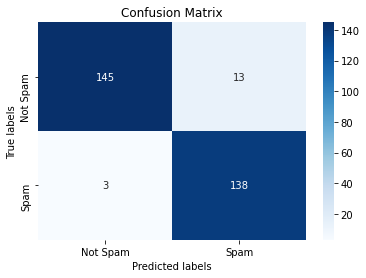

In [33]:
ax= plt.subplot()

#annot=True to annotate cells
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);

### Long Short Term Memory (LSTM) Model

In [34]:
#LSTM hyperparameters
n_lstm = 20
drop_lstm =0.2

Some new hyper-parameters used in LSTM below are n_lstm and return_sequences.
* n_lstm = 20 is the number of nodes in the hidden layers within the LSTM cell
* return_sequences = True ensures that the LSTM cell returns all of the outputs from the unrolled LSTM cell through time. If this argument is not used, the LSTM cell will simply provide the output of the LSTM cell from the previous step.

In [35]:
#LSTM Spam detection architecture
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(Dense(1, activation='sigmoid'))

#### Compiling the LSTM model

In [37]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

#### Training and evaluating LSTM model

In [39]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model1.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 5s - loss: 0.6573 - accuracy: 0.6616 - val_loss: 0.5478 - val_accuracy: 0.7167
Epoch 2/30
38/38 - 1s - loss: 0.3684 - accuracy: 0.8668 - val_loss: 0.2943 - val_accuracy: 0.9072
Epoch 3/30
38/38 - 1s - loss: 0.2577 - accuracy: 0.9229 - val_loss: 0.2534 - val_accuracy: 0.9150
Epoch 4/30
38/38 - 1s - loss: 0.2137 - accuracy: 0.9364 - val_loss: 0.2239 - val_accuracy: 0.9300
Epoch 5/30
38/38 - 1s - loss: 0.1902 - accuracy: 0.9434 - val_loss: 0.2399 - val_accuracy: 0.9284
Epoch 6/30
38/38 - 1s - loss: 0.1725 - accuracy: 0.9482 - val_loss: 0.2395 - val_accuracy: 0.9253


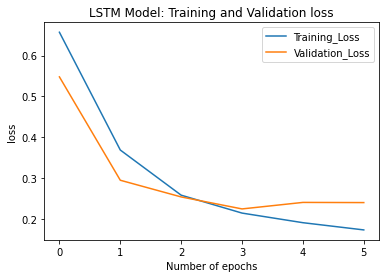

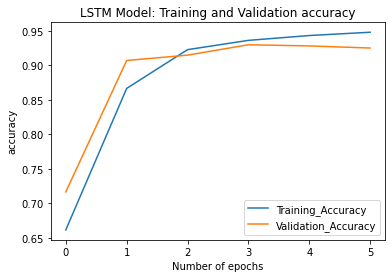

In [40]:
# Create a dataframe
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

### Bi-directional Long Short Term Memory (BiLSTM) Model
Unlike in LSTM, the Bi-LSTM learns patterns from both before and after a given token within a document. 
The Bi-LSTM back-propagates in both backward and forward directions in time. 
Due to this, the computational time is increased compared to LSTM. 
However, in most of the cases Bi-LSTM results in better accuracy.
Below, we can see the Bi-directional LSTM architecture, where only difference than LSTM 
is that we use Bidirectional wrapper to LSTM.

In [41]:
# Biderectional LSTM Spam detection architecture
model2 = Sequential()
model2.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model2.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
model2.add(Dense(1, activation='sigmoid'))

#### Compiling the BiLSTM model

In [42]:
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

#### Training and evaluation BiLSTM model

In [43]:
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model2.fit(training_padded, train_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 5s - loss: 0.6861 - accuracy: 0.5918 - val_loss: 0.6630 - val_accuracy: 0.6601
Epoch 2/30
38/38 - 1s - loss: 0.5318 - accuracy: 0.7846 - val_loss: 0.3695 - val_accuracy: 0.8666
Epoch 3/30
38/38 - 1s - loss: 0.2780 - accuracy: 0.9184 - val_loss: 0.2651 - val_accuracy: 0.9216
Epoch 4/30
38/38 - 1s - loss: 0.2025 - accuracy: 0.9437 - val_loss: 0.2369 - val_accuracy: 0.9212
Epoch 5/30
38/38 - 1s - loss: 0.1695 - accuracy: 0.9524 - val_loss: 0.2031 - val_accuracy: 0.9359
Epoch 6/30
38/38 - 1s - loss: 0.1433 - accuracy: 0.9623 - val_loss: 0.2050 - val_accuracy: 0.9375
Epoch 7/30
38/38 - 1s - loss: 0.1219 - accuracy: 0.9685 - val_loss: 0.2309 - val_accuracy: 0.9327


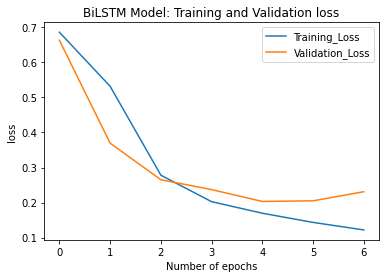

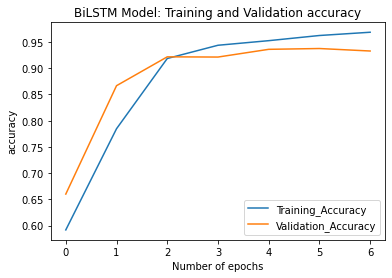

In [44]:
# Create a dataframe
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
# Plot
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

### Comparing the three different models and selecting a final one

In [51]:
# Comparing three different models
print(f"Dense architecture loss and accuracy: {model.evaluate(testing_padded, test_labels)} " )
print(f"LSTM architecture loss and accuracy: {model1.evaluate(testing_padded, test_labels)} " )
print(f"Bi-LSTM architecture loss and accuracy: {model2.evaluate(testing_padded, test_labels)} " )

10/10 [==============================] - 0s 1ms/step - loss: 0.1241 - accuracy: 0.9465
Dense architecture loss and accuracy: [0.12411334365606308, 0.9464883208274841] 
10/10 [==============================] - 0s 6ms/step - loss: 0.2395 - accuracy: 0.9253
LSTM architecture loss and accuracy: [0.23949991166591644, 0.9252843856811523] 
10/10 [==============================] - 0s 5ms/step - loss: 0.2309 - accuracy: 0.9327
Bi-LSTM architecture loss and accuracy: [0.23086325824260712, 0.9327090382575989] 


All Dense, LSTM and Bi-LSTM models are comparable in terms of loss and accuracy. 
The validation loss for these three models are 0.13, 0.31 and 0.18, respectively. 
And, the validation accuracy are 94%, 91% and 95%, respectively. 
Among all, both Dense and BiLSTM outperformed the LSTM. Based on loss, accuracy and the plots above, we select Dense architecture as a final model for classifying the text messages for spam or ham. 
The dense classifier has simple structure and the loss and accuracy over epochs are more stable than in BiLSTM.

### Predict spam/ham on new messages

In [50]:
# Defining prediction function
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model.predict(padded))

In [52]:
predict_msg = [
    "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
    "Ok lar... Joking wif u oni...", 
    "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]

predict_spam(predict_msg)

array([[0.02293411],
       [0.01012668],
       [0.99898875]], dtype=float32)

In [53]:
predict_msg = ["You are awarded a Nikon Digital Camera. Call now",
               "Call me",
               "What's up?"]

predict_spam(predict_msg)

array([[0.87937444],
       [0.04908034],
       [0.02385762]], dtype=float32)

### Next Step/Improvement

Next, we can explore more sampling approaches such as upsampling, SMOTE, overall sample. 
We can also try using different hyper-parameters, increase the sample size to improve the model further